In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os

from data_utils import SegItemListCustom, ImageListVertical, SeveralSourceDataset
from data import data_dirs as data_env, get_label_with_context

from model import (
    LinkNet34,
    accuracy_segmentation, tensorboard_cb, test_showing, jaccard_index_one_class, jaccard_index_zero_class,
    get_jaccard_index_zero_class_partial, get_jaccard_index_one_class_partial
)

from result_visualization import show_results

import torch
from torch.utils.data import DataLoader as t_Dataloader

from fastai.vision import (
    Learner,
    open_image, open_mask,
    ImageList,
    get_transforms, imagenet_stats,
    ResizeMethod, DatasetType, DataBunch,
    plt,    # matplotlib.pyplot
    nn,     # torch.nn
    optim,  # torch.optim
    Tensor, # torch.Tensor
)
from fastai.callbacks.mem import PeakMemMetric
from fastai.utils.mem import GPUMemTrace

import warnings
warnings.filterwarnings("ignore")

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

torch.cuda.init()
torch.cuda.set_device(0)
torch.cuda.is_initialized()

True

In [2]:
sizes=256

train_data = SeveralSourceDataset([data_env.get_subdir("train images skyFinder"), 
                                   data_env.get_subdir("train images raw"),
                                   data_env.get_subdir("train images sky"),
                                   data_env.get_subdir("train images labeled")
                                  ], 
                                  label_from_func=get_label_with_context, 
                                  transforms=[],
                                  batch_consistency=[12, 4, 1, 1], size=sizes)
valid_data = SeveralSourceDataset([data_env.get_subdir("test iPhoneXR images")], 
                                  label_from_func=get_label_with_context,
                                  transforms=[], size=sizes, batch_consistency=[7])
t_dl = t_Dataloader(train_data, batch_size=18, drop_last=True)
v_dl = t_Dataloader(valid_data, batch_size=7, drop_last=True)

databunch = DataBunch(t_dl, v_dl, device=torch.device("cuda:0"), )

In [3]:
model = LinkNet34(num_classes=2).cuda(0)

learner = Learner(databunch, model)
learner.model.cuda()
learner.opt_fn = optim.Adam
learner.loss_fn = nn.BCEWithLogitsLoss()  # pos_weight=Tensor([1])
learner.metrics = [accuracy_segmentation, jaccard_index_one_class, jaccard_index_zero_class]

# learner.freeze_to(1)

In [4]:
# with GPUMemTrace():
#     learner.lr_find()

In [5]:
# learner.recorder.plot(suggestion=True, show_grid=True)

In [6]:
tb_callback = tensorboard_cb("/home/dmitri/Documents/tensorboard_logs", log_name="linknet34_osp_full_s256_mlr8e02_e50_bs18_student_4src")

In [7]:
with GPUMemTrace():
    learner.fit_one_cycle(50, max_lr=8e-02, callbacks=[tb_callback(learner)])

epoch,train_loss,valid_loss,accuracy_segmentation,jaccard_index_one_class,jaccard_index_zero_class,time
0,0.148072,0.169666,0.940404,80.837702,92.038810,06:49
1,0.099233,0.118785,0.957267,85.684973,94.257914,06:47
2,0.072223,0.129946,0.937507,80.200967,91.632445,06:53
3,0.060239,0.286058,0.900120,72.213463,86.510516,06:47
4,0.055454,0.100802,0.968129,88.704157,95.748918,06:45
5,0.034459,0.163709,0.936155,80.158252,91.396419,06:54
6,0.071502,0.179887,0.933773,78.365022,91.287166,06:36
7,0.036152,0.268095,0.930032,78.872887,90.529384,06:33
8,0.036372,0.434790,0.879390,68.475629,83.657592,06:36
9,0.036704,0.650745,0.863194,65.286075,81.580183,06:39


profiler execution failed
△Used Peaked MB:    526  1,755 (exit)


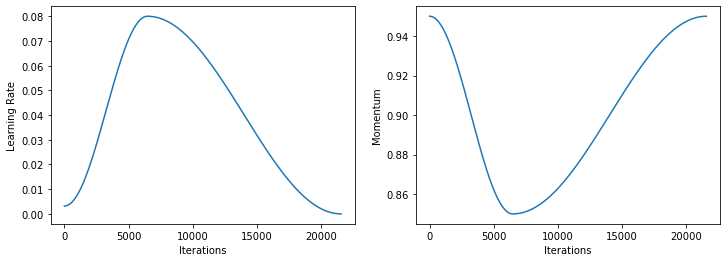

In [8]:
learner.recorder.plot_lr(show_moms=True)

In [9]:
learner.save("/home/dmitri/Documents/model_weights/linknet34/linknet34_student_4src_ops_full_e50_wghts")
# learner.export("/home/dmitri/Documents/model_weights/linknet34/linknet34_student_ops_full_e10_exp")